In [221]:
import numpy as np 
import pandas as pd 
import os

from sklearn import svm 
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer, balanced_accuracy_score 
from sklearn.pipeline import make_pipeline 
from scipy import stats 
from fitter import Fitter 
import copy 


In [222]:
import matplotlib.pyplot as plt   
import seaborn as sns  

plt.style.use('dark_background')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

In [223]:
df = pd.read_csv("data/games.csv")
df.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


In [224]:
df = df.sort_values(by='GAME_DATE_EST').reset_index(drop = True)
df = df.loc[df['GAME_DATE_EST'] >= "2004-01-01"].reset_index(drop=True)
df.isnull().values.any() 

False

In [225]:
df_names = pd.read_csv('data/teams.csv')
df_names.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


In [226]:
df_names = df_names[['TEAM_ID', 'NICKNAME']]

home_names = df_names.copy() 
home_names.columns = ['HOME_TEAM_ID', 'NICKNAME'] 

result_1 = pd.merge(df['HOME_TEAM_ID'], home_names, how ="left", on="HOME_TEAM_ID")  
df['HOME_TEAM_ID'] = result_1['NICKNAME']

visitor_names = df_names.copy() 
visitor_names.columns = ['VISITOR_TEAM_ID', 'NICKNAME'] 
result_2 = pd.merge(df['VISITOR_TEAM_ID'], visitor_names, how = "left", on="VISITOR_TEAM_ID")
df['VISITOR_TEAM_ID'] = result_2['NICKNAME']

In [227]:
df.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2004-01-02,20300458,Final,Timberwolves,Hawks,2003,1610612750,93.0,0.409,0.929,...,32.0,56.0,1610612737,75.0,0.372,0.737,0.375,22.0,31.0,1
1,2004-01-02,20300451,Final,Wizards,Warriors,2003,1610612764,97.0,0.446,0.611,...,30.0,58.0,1610612744,79.0,0.403,0.818,0.381,20.0,36.0,1
2,2004-01-02,20300454,Final,Knicks,Bulls,2003,1610612752,99.0,0.470,0.800,...,25.0,38.0,1610612741,104.0,0.488,0.724,0.385,20.0,44.0,0
3,2004-01-02,20300457,Final,Pistons,Suns,2003,1610612765,93.0,0.389,0.947,...,26.0,54.0,1610612756,81.0,0.395,0.895,0.364,20.0,34.0,1
4,2004-01-02,20300456,Final,Heat,Magic,2003,1610612748,112.0,0.466,0.792,...,29.0,42.0,1610612753,101.0,0.430,0.750,0.450,15.0,37.0,1


In [228]:
df = df.loc[df['GAME_DATE_EST'] < '2020-08-01'].reset_index(drop=True)

In [229]:
feature_list = list(df.columns)
feature_list

['GAME_DATE_EST',
 'GAME_ID',
 'GAME_STATUS_TEXT',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON',
 'TEAM_ID_home',
 'PTS_home',
 'FG_PCT_home',
 'FT_PCT_home',
 'FG3_PCT_home',
 'AST_home',
 'REB_home',
 'TEAM_ID_away',
 'PTS_away',
 'FG_PCT_away',
 'FT_PCT_away',
 'FG3_PCT_away',
 'AST_away',
 'REB_away',
 'HOME_TEAM_WINS']

In [230]:
selected_features = [
    'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
    'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away',
    ]

X = df[selected_features]
X.head()

,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away
0,0.409,0.929,0.308,32.0,56.0,0.372,0.737,0.375,22.0,31.0
1,0.446,0.611,0.400,30.0,58.0,0.403,0.818,0.381,20.0,36.0
2,0.470,0.800,0.333,25.0,38.0,0.488,0.724,0.385,20.0,44.0
3,0.389,0.947,0.238,26.0,54.0,0.395,0.895,0.364,20.0,34.0
4,0.466,0.792,0.500,29.0,42.0,0.430,0.750,0.450,15.0,37.0


In [231]:
y = df['HOME_TEAM_WINS']
y.head()

0    1
1    1
2    0
3    1
4    1
Name: HOME_TEAM_WINS, dtype: int64

In [232]:
X = X.to_numpy()
y = y.to_numpy()

In [233]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, random_state=42)

print("X shape", X_train.shape, "y shape", y_train.shape)

X shape (15920, 10) y shape (15920,)


In [234]:
scaler = StandardScaler()  
X_train = scaler.fit_transform(X_train) 

In [235]:
clf = svm.SVC(kernel='linear') 
clf.fit(X_train, y_train) 
 
y_pred = clf.predict(X_test) 
print('balanced accuracy score:', balanced_accuracy_score(y_test, y_pred)) 

balanced accuracy score: 0.6878585411727729


In [255]:
from sklearn.metrics import f1_score
# F1 Score
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)


F1 Score: 0.7877232142857143


In [256]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

rf_clf = RandomForestClassifier()
gb_clf = GradientBoostingClassifier()

rf_clf.fit(X_train, y_train)
gb_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_pred_gb = gb_clf.predict(X_test)

# Evaluate other models
print("Random Forest:")
print('F1 Score:', f1_score(y_test, y_pred_rf))
print('balanced accuracy score:', balanced_accuracy_score(y_test, y_pred_rf))

print("Gradient Boosting:")
print('F1 Score:', f1_score(y_test, y_pred_gb))
print('balanced accuracy score:', balanced_accuracy_score(y_test, y_pred_gb))


Random Forest:
F1 Score: 0.7381370826010545
balanced accuracy score: 0.5001027310714683
Gradient Boosting:
F1 Score: 0.7424214245862004
balanced accuracy score: 0.5107735782409043


In [238]:
scoring = make_scorer(balanced_accuracy_score)
param_grid = {'C': [0.1, 1, 10],  
              'gamma': [1,0.1,0.01]} #

grid = GridSearchCV(svm.SVC(kernel='linear'), param_grid, scoring = scoring, refit=True, verbose=2) 
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .....................................C=0.1, gamma=1; total time=   2.2s
[CV] END .....................................C=0.1, gamma=1; total time=   2.1s
[CV] END .....................................C=0.1, gamma=1; total time=   2.0s
[CV] END .....................................C=0.1, gamma=1; total time=   2.3s
[CV] END .....................................C=0.1, gamma=1; total time=   2.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   2.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   2.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   2.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   2.2s
[CV] END ...................................C=0.1, gamma=0.1; total time=   2.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   2.0s
[CV] END ..................................C=0.1,

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]},
             scoring=make_scorer(balanced_accuracy_score), verbose=2)

In [239]:
Dis = grid.best_estimator_
print(Dis) 

SVC(C=0.1, gamma=1, kernel='linear')


In [240]:
df_ = df.loc[df['GAME_DATE_EST'] > '2019-10-01'].reset_index(drop=True)
df_.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2019-10-04,11900003,Final,Kings,Pacers,2019,1610612758,131.0,0.494,0.778,...,30.0,30.0,1610612754,132.0,0.516,0.788,0.370,26.0,47.0,0
1,2019-10-04,11900002,Final,Clippers,Rockets,2019,1610612746,96.0,0.384,0.600,...,26.0,49.0,1610612745,109.0,0.375,0.800,0.229,21.0,52.0,0
2,2019-10-05,11900006,Final,Warriors,Lakers,2019,1610612744,101.0,0.393,0.769,...,20.0,47.0,1610612747,123.0,0.475,0.633,0.303,32.0,58.0,0
3,2019-10-05,11900007,Final,Spurs,Magic,2019,1610612759,89.0,0.388,0.750,...,22.0,40.0,1610612753,125.0,0.526,0.714,0.361,29.0,47.0,0
4,2019-10-05,11900005,Final,Pacers,Kings,2019,1610612754,130.0,0.521,0.944,...,35.0,51.0,1610612758,106.0,0.378,0.780,0.353,24.0,35.0,1


In [241]:
selected_distributions = [
    'norm','t', 'f', 'chi', 'cosine', 'alpha', 
    'beta', 'gamma', 'dgamma', 'dweibull',
    'maxwell', 'pareto', 'fisk']

In [242]:
unique_teams = df['HOME_TEAM_ID'].unique() 

all_team_sim_data = {}

for team_name in unique_teams:
    df_team = df_.loc[(df_['HOME_TEAM_ID'] == team_name) | (df_['VISITOR_TEAM_ID'] == team_name)]
    df_1 = df_team.loc[df_team['HOME_TEAM_ID'] == team_name][selected_features[:5]]
    df_0 = df_team.loc[df_team['VISITOR_TEAM_ID'] == team_name][selected_features[5:]]

    df_0.columns = df_1.columns 
    df_s = pd.concat([df_1, df_0], axis = 0)
    
    all_team_sim_data[team_name] = df_s.to_numpy()

In [258]:
megadata = {} 
for team_name in unique_teams:
    feature_dis_paras = []
    data = all_team_sim_data[team_name]
    
    for i in range(5): 
        f = Fitter(data[:, i]) 
        f.distributions = selected_distributions 
        f.fit()  
        best_paras = f.get_best(method='sumsquare_error') 
        feature_dis_paras.append(best_paras)
        
    megadata[team_name] = feature_dis_paras
    

In [244]:
DATA = megadata.copy() 

GEN = {
 'alpha': stats.alpha.rvs,
 'beta': stats.beta.rvs,
 'chi': stats.chi.rvs,
 'cosine': stats.cosine.rvs,
 'dgamma': stats.dgamma.rvs,
 'dweibull':stats.dweibull.rvs,
 'f':stats.f.rvs,
 'fisk':stats.fisk.rvs,
 'gamma': stats.gamma.rvs,
 'maxwell':stats.maxwell.rvs,
 'norm':stats.norm.rvs,
 'pareto':stats.pareto.rvs,
 't':stats.t.rvs,
}

In [245]:
DIS = make_pipeline(scaler, Dis)

In [246]:
class Game:
        
    def __init__ (self, random_state = None):
        self.random_state = random_state 
    
    def predict(self, team1, team2, num_games = 1):
        assert num_games >= 1, "at least one game must be played"

        team_1_feature_data = DATA[team1]
        team_2_feature_data = DATA[team2]
        features = []
        for feature_paras_1 in team_1_feature_data:
            sample_1 = self.sampling(feature_paras_1, size = num_games) 
            features.append(sample_1) 
            
        for feature_paras_2 in team_2_feature_data:
            sample_2 = self.sampling(feature_paras_2, size = num_games) 
            features.append(sample_2)
            
        features = np.array(features).T 
        win_loss = DIS.predict(features)
        
        return list(win_loss) 
    
    
    def sampling(self, dic, size = 1, random_state = None):                        
        dis_name = list(dic.keys())[0] 
        paras = list(dic.values())[0] 
    
        sample = GEN[dis_name](*paras.values(), size = size,  random_state =  random_state)
            
        return sample 

In [247]:
class FinalTournament(Game):
    def __init__(self, n_games_per_group = 7, winning_threshold = 4, random_state = None):

        self.n_games_per_group  = n_games_per_group
        self.winning_threshold = winning_threshold
        self.team_list = None
        self.rounds = {} 
        super().__init__(random_state)
        
    
    def simulate(self, group_list, n_simulation = 1, probs = True):
        
        self.rounds = {}
        self.team_list = [i[0] for i in group_list] + [i[1] for i in group_list]
        
        for i in range(n_simulation):
            cham = self.one_time_simu(group_list)
        if probs:
            self.rounds_probs =  self._compute_probs()
            
    
    def one_time_simu(self, group_list, verbose = False, probs = False):
        
        if self.team_list == None: 
            self.team_list = [i[0] for i in group_list] + [i[1] for i in group_list]
        round_number, done = 0, 0
        while not done: 
            # se joaca o runda de meciuri bazat pe lista de echipe
            all_group_winners, group_list = self.play_round(group_list) 
            # extrage stats ale rundei
            try:
                updated_round_stats = self.rounds[round_number]
            except KeyError:
                updated_round_stats = {}
                for team in self.team_list:
                    updated_round_stats[team] = 0
            # daca o echipa castiga atunci ii adaugam un punct
            for winner in all_group_winners:
                try: 
                    updated_round_stats[winner] += 1
                except KeyError:
                    pass     
            self.rounds[round_number] = updated_round_stats
            if verbose:
                print('{} round played'.format(round_number))
            if probs:
                self.rounds_probs = self._compute_probs()
            if type(group_list) != list: # daca am ajuns la final
                done = 1
            round_number += 1
            
        return group_list

        
    def play_round(self, group_list):
        
        all_group_winners = [] 
        # se joaca meciurile din grupe si se extrage castigatorul
        for group in group_list:
            winner = self.play_n_games(group[0], group[1]) # aplic functia de mai jos pentru a determina castigatorul dintre echipele din grupa
            all_group_winners.append(winner)
        
        if len(all_group_winners) > 1: # daca nu suntem la runda finala
            new_group_list = []   # o noua lista initializata pentru urmatoarea runda      
            for index in range(0, len(all_group_winners), 2):
                # first winner, second winner
                new_group = [all_group_winners[index], all_group_winners[index + 1]] # cream o noua grupa cu castigatorii din grupa anterioara
                new_group_list.append(new_group)
                
            return all_group_winners, new_group_list
        else:  
            return all_group_winners, winner # daca suntem la final, returnam castigatorul
        
        
    def play_n_games(self, team1, team2):
        
        result = Game().predict(team1, team2, self.n_games_per_group)
        if sum(result[:4]) == self.winning_threshold or sum(result) >= self.winning_threshold: # daca o echipa castiga 4 meciuri sau mai mult
            winner = team1 # echipa gazda castiga
        else:
            winner = team2 # echpa oaspete castiga
            
        return winner
    
    
    def _compute_probs(self): # calculeaza probabilitatea ca o echipa sa castige runda curenta
        
        rounds_probs = copy.deepcopy(self.rounds)
        for round_number, round_stats in rounds_probs.items():
            m = np.sum(list(round_stats.values()))
            for k, v in rounds_probs[round_number].items():
                rounds_probs[round_number][k] = v / m # probabilitatea ca o echipa sa castige runda curenta impartind numarul de victorii la suma totala de meciuri jucate
                
        return rounds_probs

In [248]:
group_list = [
     # Eastern Conference
     ('Bucks', 'Magic'),  
     ('Pacers', 'Heat'), 
    
     ('Celtics', '76ers'), 
     ('Raptors', 'Nets'), 
    
     # Western Conference
     ('Lakers','Trail Blazers'), 
     ('Rockets','Thunder'),
    
     ('Nuggets', 'Jazz'), 
     ('Clippers', 'Mavericks')] 

In [249]:
playoff = FinalTournament()
playoff.simulate(group_list, n_simulation = 5000)

CPU times: total: 2min 29s
Wall time: 2min 34s


In [250]:
playoff.rounds_probs

{0: {'Bucks': 0.122825,
  'Pacers': 0.069275,
  'Celtics': 0.0705,
  'Raptors': 0.074175,
  'Lakers': 0.1,
  'Rockets': 0.048075,
  'Nuggets': 0.081575,
  'Clippers': 0.081275,
  'Magic': 0.002175,
  'Heat': 0.055725,
  '76ers': 0.0545,
  'Nets': 0.050825,
  'Trail Blazers': 0.025,
  'Thunder': 0.076925,
  'Jazz': 0.043425,
  'Mavericks': 0.043725},
 1: {'Bucks': 0.19215,
  'Pacers': 0.02835,
  'Celtics': 0.09435,
  'Raptors': 0.047,
  'Lakers': 0.15345,
  'Rockets': 0.0162,
  'Nuggets': 0.1149,
  'Clippers': 0.05215,
  'Magic': 0.0007,
  'Heat': 0.0288,
  '76ers': 0.077,
  'Nets': 0.03165,
  'Trail Blazers': 0.03015,
  'Thunder': 0.0502,
  'Jazz': 0.0577,
  'Mavericks': 0.02525},
 2: {'Bucks': 0.3534,
  'Pacers': 0.0463,
  'Celtics': 0.0156,
  'Raptors': 0.0095,
  'Lakers': 0.2231,
  'Rockets': 0.0132,
  'Nuggets': 0.0888,
  'Clippers': 0.0323,
  'Magic': 0.0004,
  'Heat': 0.0496,
  '76ers': 0.0209,
  'Nets': 0.0043,
  'Trail Blazers': 0.0302,
  'Thunder': 0.0606,
  'Jazz': 0.0386,
  

In [259]:
def plotting(rounds_data):
    
    rounds_stats = list(rounds_data.values())
    team_names = list(rounds_stats[0].keys())
    
    x = list(rounds_data.keys())
    y = np.array([list(r.values()) for r in rounds_stats]).T 
    
    c_1 =  sns.color_palette('tab10', n_colors = 10)
    c_2 =  sns.color_palette("pastel", n_colors = 10)
    color_map = c_1 + c_2 
    
    fig = plt.figure()
    plt.stackplot(x, y, labels = team_names, colors = color_map) 
    plt.legend(bbox_to_anchor=(1.1, 1.1), loc = 'upper left', fontsize=13)
    plt.xticks(x, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Runda', fontsize = 15)
    plt.title('Sansele de castig ale tuturor echipelor', pad = 20, fontsize = 24)
    plt.tight_layout()
    plt.show()
    
    return fig

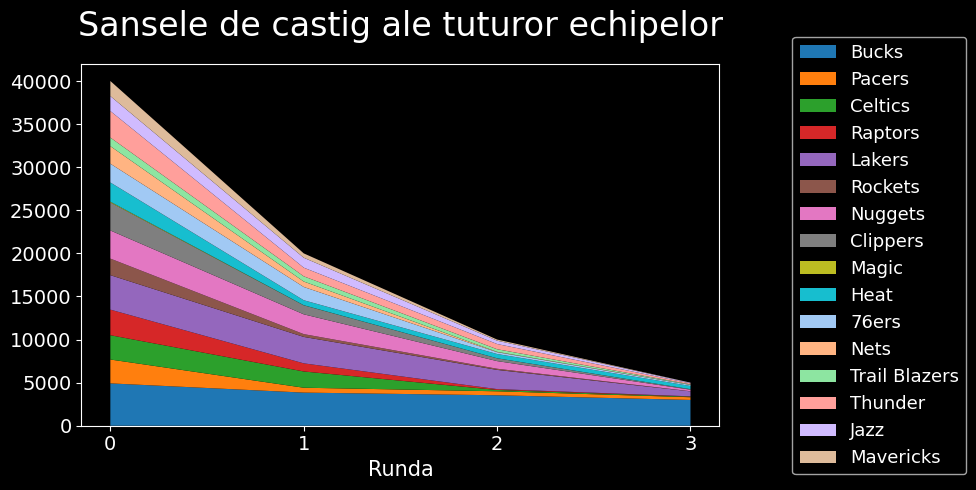

In [260]:
fig = plotting(playoff.rounds)

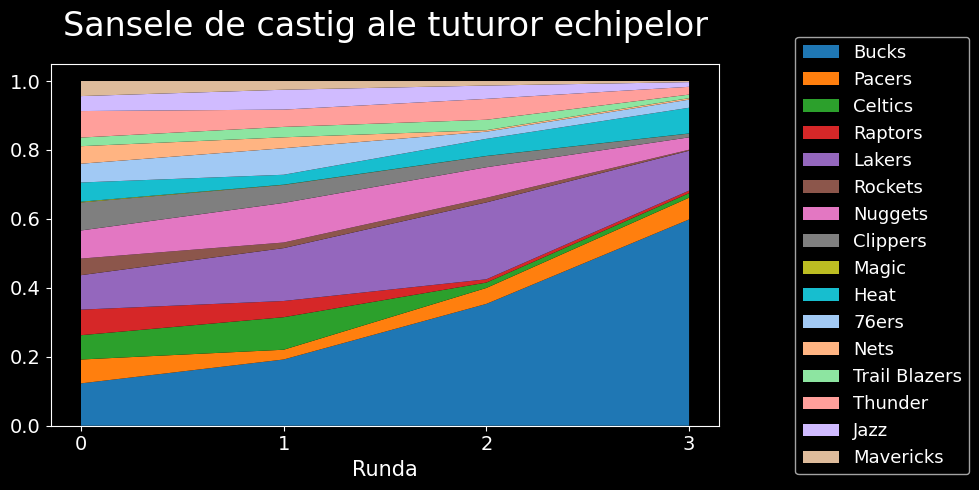

In [261]:
fig = plotting(playoff.rounds_probs)

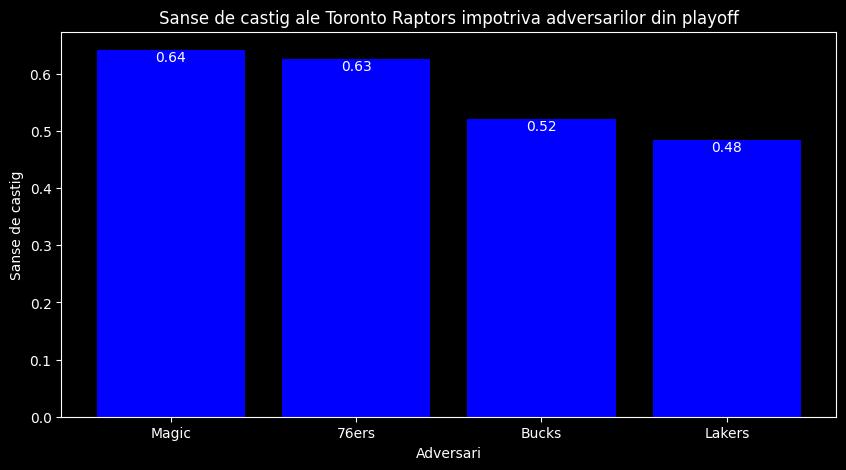

In [262]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_chances(df, home_team, away_team):
    df_1 = df.loc[(df['HOME_TEAM_ID'] == home_team) & (df['VISITOR_TEAM_ID'] == away_team)].reset_index(drop=True)
    df_2 = df.loc[(df['HOME_TEAM_ID'] == away_team) & (df['VISITOR_TEAM_ID'] == home_team)].reset_index(drop=True)
    total_wins = sum(df_1['HOME_TEAM_WINS']) + (df_2.shape[0] - sum(df_2['HOME_TEAM_WINS']))
    total_games = df_1.shape[0] + df_2.shape[0]
    return total_wins / total_games if total_games != 0 else 0

raptors_vs_magic = calculate_chances(df, 'Raptors', 'Magic')
raptors_vs_sixers = calculate_chances(df, 'Raptors', '76ers')
raptors_vs_bucks = calculate_chances(df, 'Raptors', 'Bucks')
raptors_vs_lakers = calculate_chances(df, 'Raptors', 'Lakers')

chances_dict = {
    'Magic': raptors_vs_magic,
    '76ers': raptors_vs_sixers,
    'Bucks': raptors_vs_bucks,
    'Lakers': raptors_vs_lakers
}

opponents = list(chances_dict.keys())
chances = list(chances_dict.values())

plt.bar(opponents, chances, color='blue')

plt.xlabel('Adversari')
plt.ylabel('Sanse de castig')
plt.title('Sanse de castig ale Toronto Raptors impotriva adversarilor din playoff')

for i, chance in enumerate(chances):
    plt.text(i, chance - 0.02, str(round(chance, 2)), ha='center')

plt.show()
